In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from scipy.special import expit as sigmoid 
%matplotlib inline

In [3]:
# Default figure size
plt.rcParams['figure.figsize'] = (10,6)

In [4]:
# Load Data
Data = np.load('Data.npz')
Data.files

['X', 'labels']

In [17]:
# Assinging the samples to 'X' and labels to 'y'
# Reshaping X as (n x m) --> (Features x samples)
X = Data['X']
y = Data['labels']
y = y.reshape(1,-1)
print ("Dimensions of X (Features(n) x Examples(m)):",X.shape)
print ("\nDiemsions of Y:",y.shape)

Dimensions of X (Features(n) x Examples(m)): (2, 400)

Diemsions of Y: (1, 400)


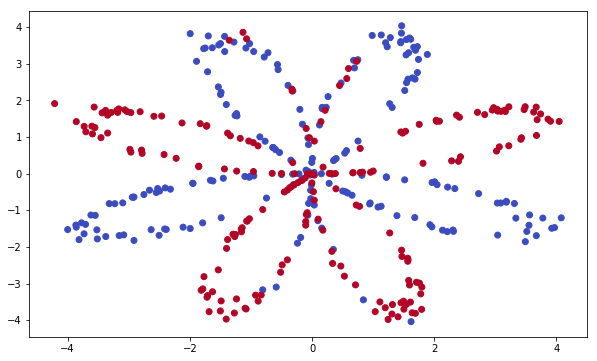

In [18]:
# Visulizing the dataset
plt.scatter(X[0], X[1], c=y.ravel(), cmap=plt.cm.coolwarm)
plt.show()

In [7]:
# Initializing parameters
def init_params(units):
    W1 = tf.get_variable('W1',[units,2],initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1',[units,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[1,units],initializer = tf.contrib.layers.xavier_initializer(seed=2))
    b2 = tf.get_variable('b2',[1,1],initializer=tf.zeros_initializer())
    
    params = {'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    
    return params


In [8]:
# Forward Prop
# TanH used as the activation function
def forward_prop(X,params):
    # Retriving from params
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    Z1 = tf.matmul(W1,X) + b1
    A1 = tf.nn.tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2 
    
    return Z2

In [9]:
# Cost Function
def cost_fun(Z2,y,reg_term):
    
    m = (Z2.get_shape().as_list()[1])
    #print ('Shape:',m) 
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2,
                                                  labels=y))
    cost += reg_term/m
    
    return cost

In [19]:
# Function to implement a two layer Neural Network
def model(data,labels,alpha = 0.01,iterations = 2000, h_units=4,lamb=0.0):
    
    ops.reset_default_graph()
    hist_cost = []
    
    X = tf.placeholder(tf.float32, shape=(data.shape), name='X')
    Y = tf.placeholder(tf.float32,shape=(labels.shape), name = 'Y')
    
    params = init_params(h_units)
    
    regularizer = tf.contrib.layers.l2_regularizer(scale=lamb)
    reg_term = tf.contrib.layers.apply_regularization(regularizer,[params['W1'],params['W2']])
  
    Z2 = forward_prop(X,params)
    
    cost = cost_fun(Z2,Y,reg_term)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(iterations):
            _ , c = sess.run([optimizer,cost],feed_dict= {X:data, Y:labels})
            hist_cost.append(c)
            if i%200 == 0:
                print("Cost after iteration %i: %f" %(i,c))
        print("Cost after iteration %i: %f" %(i,c))       
        
        plt.plot(np.squeeze(hist_cost))
        plt.ylabel('Cost')
        plt.xlabel('Itertaions')
        plt.title('Learing Rate = '+ str(alpha))
        plt.show()
        
        parameters = sess.run(params)
    
    return parameters    
    

Cost after iteration 0: 0.779149
Cost after iteration 200: 0.423040
Cost after iteration 400: 0.354591
Cost after iteration 600: 0.332802
Cost after iteration 800: 0.322884
Cost after iteration 1000: 0.317603
Cost after iteration 1200: 0.314569
Cost after iteration 1400: 0.312752
Cost after iteration 1600: 0.311624
Cost after iteration 1800: 0.310884
Cost after iteration 1999: 0.310338


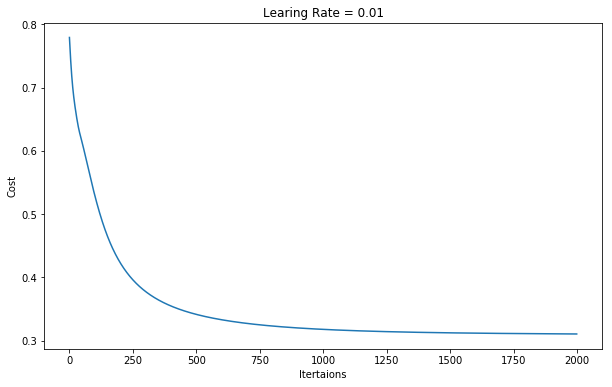

In [11]:
# 2 layer NN 
# 2 Dimensional data fed as input to the network
# 4 units in the hidden layer
# 1 unit in the output layer (binary classifier)
# Tanh activation function
parameters = model(X,y,lamb=0.1,h_units=4)

In [12]:
# Creating a tensorboard graph
#writer = tf.summary.FileWriter('.')
#writer.add_graph(tf.get_default_graph())

In [13]:
# Predicting  the class for each sample
def predict(X,parameters):
    X_tensor = tf.convert_to_tensor(X,dtype = tf.float32)
    X_tensor = forward_prop(X_tensor,parameters)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init) 
        Z = sess.run(X_tensor)
    
    pred = sigmoid(Z) > 0.5 
    return pred    

In [14]:
# Initializing and Predictng on the grid
def grid(X,parameters):
    xmin, xmax = X[0].min() -1, X[0].max() +1
    ymin, ymax = X[1].min() -1, X[1].max() +1
    u = np.linspace(xmin,xmax,500, dtype=np.float32)
    v = np.linspace(ymin,ymax,500, dtype=np.float32)
    xx,yy = np.meshgrid(u,v,indexing='xy')
    Z = np.c_[xx.ravel(),yy.ravel()].T
    pred = predict(Z,parameters)
    

    return xx,yy,pred.reshape(xx.shape)
    

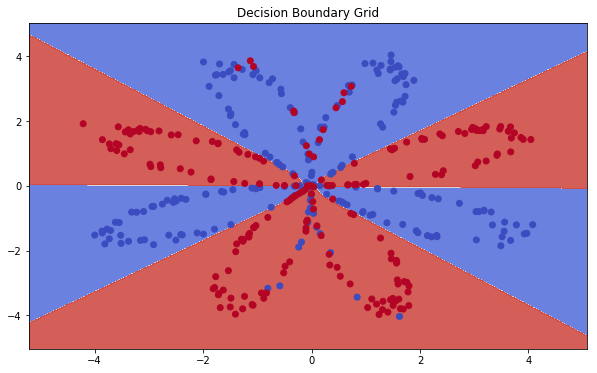

In [15]:
# Plotting the Decision Grid
xx,yy,Z = grid(X,parameters)
plt.contourf(xx, yy, Z, alpha=0.85, cmap=plt.cm.coolwarm)
plt.scatter(X[0], X[1], c=y.ravel(), cmap=plt.cm.coolwarm)
plt.title("Decision Boundary Grid")
plt.show()

In [16]:
# Print Accuracy on the dataset
pred_y = predict(X,parameters)
acc = np.mean(pred_y.flatten()==y.flatten())*100
print('Accuracy on the dataset: %s %%' %round(acc,2))

Accuracy on the dataset: 89.25 %
